In [1]:
# This Python 3 environment is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Initial EDA

In [2]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

#train_data.head()

In [3]:
#test_data.head()

In [4]:
# find missing values and print data dimensions
print("Training:\n", train_data.shape, "\n")
print(train_data.isnull().sum(),"\n\n")
print("Test:\n", test_data.shape, "\n")
print(test_data.isnull().sum())

Training:
 (8693, 14) 

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64 


Test:
 (4277, 13) 

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


<AxesSubplot:>

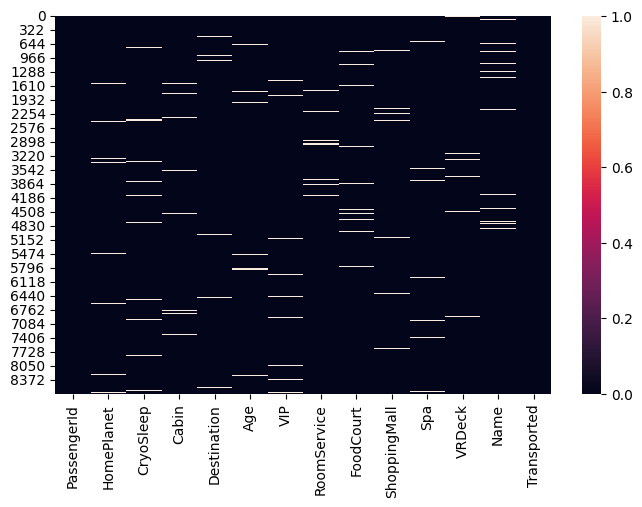

In [5]:
# visualize missing values
plt.figure(dpi=100, figsize=(8, 5))
sns.heatmap(train_data.isnull())

In [6]:
train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [7]:
train_data.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [8]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [9]:
for c in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']:
    print(train_data[c].value_counts(), "\n")

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64 

False    5439
True     3037
Name: CryoSleep, dtype: int64 

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64 

False    8291
True      199
Name: VIP, dtype: int64 



# New Features

### Separate information in PassengerId and Cabin into new features

In [10]:
# separate information in PassengerID 
train_data[['GroupId', 'MemberId']] = train_data['PassengerId'].str.split("_", expand=True)

# separate information in Cabin
train_data[['CabinDeck', 'CabinNum', 'CabinSide']] = train_data['Cabin'].str.split("/", expand=True)

#train_data.head()

In [11]:
for c in ['CabinDeck', 'CabinNum', 'CabinSide']:
    print(train_data[c].value_counts(), "\n")

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: CabinDeck, dtype: int64 

82      28
86      22
19      22
56      21
176     21
        ..
1644     1
1515     1
1639     1
1277     1
1894     1
Name: CabinNum, Length: 1817, dtype: int64 

S    4288
P    4206
Name: CabinSide, dtype: int64 



In [12]:
train_data['CabinNum'].astype('float').describe()

count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: CabinNum, dtype: float64

### Create a total spending feature

In [13]:
# create a total spending feature
train_data['TotalSpend'] = train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [14]:
# check that people in CryoSleep are not spending money
train_data.groupby('CryoSleep')['TotalSpend'].describe()

,count,mean,std,min,25%,50%,75%,max
CryoSleep,,,,,,,,
False,5439.0,2248.299687,3245.061489,0.0,746.0,1019.0,2416.0,35987.0
True,3037.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


### Create a feature for group size

In [15]:
# create a feature for group size
train_data['GroupSize'] = train_data.groupby('GroupId')['GroupId'].transform('count')
#train_data.head()

# EDA with new features

In [16]:
# find mutual information scores

from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer

mi_df = train_data.copy()
mi_df = mi_df.drop(['PassengerId', 'Name', 'MemberId', 'Cabin'], axis=1)  # drop the columns with unique or useless identifiers

# impute missing values
categ_imputer = SimpleImputer(strategy = 'most_frequent')
num_imputer = SimpleImputer(strategy = 'constant')

categ_cols = [cname for cname in mi_df.columns if mi_df[cname].dtype == "object"]
num_cols = [cname for cname in mi_df.columns if mi_df[cname].dtype in ['int64', 'float64']]

mi_df[categ_cols] = pd.DataFrame(categ_imputer.fit_transform(mi_df[categ_cols]))
mi_df[num_cols] = pd.DataFrame(num_imputer.fit_transform(mi_df[num_cols]))

# Label encoding for categoricals
for colname in mi_df.select_dtypes(["object", "bool"]):
    mi_df[colname], _ = mi_df[colname].factorize()
    
X = mi_df.copy()
y = X.pop("Transported")

# select discrete/categorical columns
discrete_feat = discrete_features = X.dtypes == int

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_feat)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

GroupId         0.512914
CabinNum        0.143284
TotalSpend      0.136447
CryoSleep       0.112254
Spa             0.073539
VRDeck          0.072811
RoomService     0.062571
ShoppingMall    0.046517
FoodCourt       0.041131
CabinDeck       0.022989
HomePlanet      0.018581
GroupSize       0.011538
Destination     0.006113
CabinSide       0.005149
VIP             0.000700
Age             0.000000
Name: MI Scores, dtype: float64

Text(0.5, 1.0, 'Mutual Information Scores')

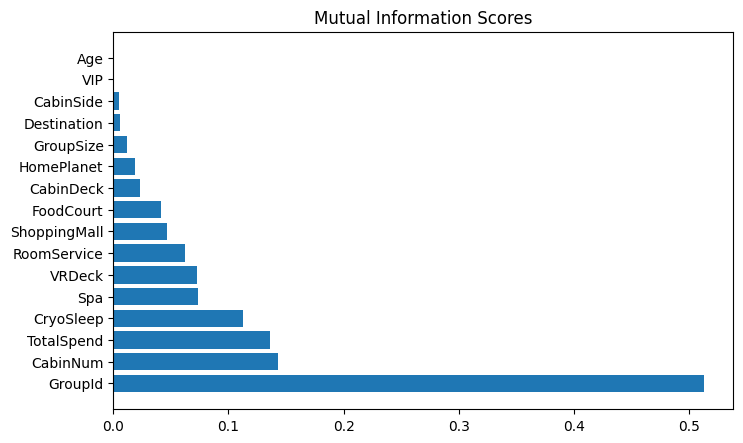

In [17]:
# plot mutual information scores

plt.figure(dpi=100, figsize=(8, 5))
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")

# Deal with Missing Values

In [18]:
# modified a function found here -> https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
# this function is more computationally efficient than using the mode() function

from collections import Counter

def Most_Common(lst):
    data = Counter(lst.dropna())
    if len(data) > 0:
        return data.most_common(1)[0][0]
    else:
        return None

In [19]:
def impute_group_value(df, columns, group_var, default_most_common = True):
    """ 
    function to impute the most common value within a group for specified columns
        variables:
            df: the dataframe containing some missing values
            cols: a list of column names whose missing values are to be imputed
            group_var: the name of the column/variable that identifies the groups within the data
            default_most_common: if true, assign the most common value for the entire column for groups with only missing values; if false assign 'Unknown'
    """
    for c in columns:
        # assign the most common value in the group, if the group size is >1 and at least one value in the group is not missing
        df.loc[df[c].isnull(), c] = df[group_var].map(df.groupby([group_var])[c].agg(Most_Common))
        # assign the most common value in the entire column (for all group combined), or -1, for all other groups
        if default_most_common:
            df.loc[df[c].isnull(), c] = Most_Common(df[c])
        else:
            df.loc[df[c].isnull(), c] = "Unknown"
        
    return df

In [20]:
"""train_data3 = train_data.copy()

# impute by group or most common in entire column: HomePlanet, CryoSleep, Destination, VIP
group_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
train_data3 = impute_group_value(train_data3, group_cols, group_var='GroupId')

# impute by group or with a -1: CabinDeck, CabinNum, CabinSide
group_cols = ['CabinDeck', 'CabinNum', 'CabinSide']
train_data3 = impute_group_value(train_data3, group_cols, group_var='GroupId', default_most_common=False)

# impute with the median: Age
train_data3.loc[train_data3['Age'].isnull(),'Age'] = train_data3['Age'].median()

# impute a 0 if CryoSleep is true, otherwise the median of the entire column: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for s in spend_cols:
    train_data3.loc[(train_data3[s].isnull() & train_data3['CryoSleep']), s] = 0
    train_data3.loc[train_data3[s].isnull(), s] = train_data3[s].median()"""
    
# do not use in model (so imputation is unnecessary): PassengerId, MemberId, Cabin, Name
# do not have any missing values (making imputation unnecessary): GroupId, GroupSize, TotalSpend

"train_data3 = train_data.copy()\n\n# impute by group or most common in entire column: HomePlanet, CryoSleep, Destination, VIP\ngroup_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']\ntrain_data3 = impute_group_value(train_data3, group_cols, group_var='GroupId')\n\n# impute by group or with a -1: CabinDeck, CabinNum, CabinSide\ngroup_cols = ['CabinDeck', 'CabinNum', 'CabinSide']\ntrain_data3 = impute_group_value(train_data3, group_cols, group_var='GroupId', default_most_common=False)\n\n# impute with the median: Age\ntrain_data3.loc[train_data3['Age'].isnull(),'Age'] = train_data3['Age'].median()\n\n# impute a 0 if CryoSleep is true, otherwise the median of the entire column: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck\nspend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']\nfor s in spend_cols:\n    train_data3.loc[(train_data3[s].isnull() & train_data3['CryoSleep']), s] = 0\n    train_data3.loc[train_data3[s].isnull(), s] = train_data3[s].median()"

recalculate TotalSpend after imputation?

# Models

### Modeling using specialized (context-specific) imputation

In [21]:
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Identify predictors to be used
features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP',
           'CabinDeck', 'CabinNum', 'CabinSide', 'Age',
           #'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
           'GroupId', 'TotalSpend'] #'GroupSize', 

In [22]:
# predictors not used in model (so imputation is unnecessary): PassengerId, MemberId, Cabin, Name
# predictors without any missing values (making imputation unnecessary): GroupId, GroupSize, TotalSpend

# impute by group or most common in entire column: HomePlanet, CryoSleep, Destination, VIP
group_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
train_data = impute_group_value(train_data, group_cols, group_var='GroupId')

# impute by group or with a -1: CabinDeck, CabinNum, CabinSide
group_cols = ['CabinDeck', 'CabinNum', 'CabinSide']
train_data = impute_group_value(train_data, group_cols, group_var='GroupId', default_most_common=False)

# impute with the median: Age
train_data.loc[train_data['Age'].isnull(),'Age'] = train_data['Age'].median()

# impute a 0 if CryoSleep is true, otherwise the median of the entire column: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for s in spend_cols:
    train_data.loc[(train_data[s].isnull() & train_data['CryoSleep']), s] = 0
    train_data.loc[train_data[s].isnull(), s] = train_data[s].median()

In [23]:
# Separate target from predictors (target has no missing values)
y = train_data.Transported
X = train_data[features]

encoder = OneHotEncoder(handle_unknown='ignore')
X = encoder.fit_transform(X)

# define the xgb model
xgb_model = XGBClassifier()

n_est = np.arange(10, 150, step = 20).tolist()
learn_rate = np.arange(0.05, 0.55, step = 0.05).tolist()
parameters = {'n_estimators': n_est,
             'learning_rate': learn_rate}

my_xgb_model = GridSearchCV(xgb_model, 
                            param_grid=parameters,
                            scoring='accuracy')

In [24]:
# fit xgb model 
my_xgb_model.fit(X, y)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     n

In [25]:
print("Best Parameters:\n", my_xgb_model.best_params_, "\n")
print("Best Score:\n", my_xgb_model.best_score_)

Best Parameters:
 {'learning_rate': 0.4, 'n_estimators': 30} 

Best Score:
 0.7453146557913592


### Modeling using general sci-kit learn imputation (and pipelines)

In [26]:
"""from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Identify predictors to be used
features = ['HomePlanet', 'CryoSleep', 'Destination', 'Age',
            'GroupId', 'CabinDeck', 'CabinNum', 'CabinSide', 
            'TotalSpend', 'GroupSize'] 

# Separate target from predictors (target has no missing values)
y = train_data.Transported
X = train_data[features]

# select categorical columns
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# define the xgb model
xgb_model = XGBClassifier()

n_est = np.arange(10, 150, step = 20).tolist()
learn_rate = np.arange(0.05, 0.55, step = 0.05).tolist()
parameters = {'n_estimators': n_est,
             'learning_rate': learn_rate}

my_xgb_model = GridSearchCV(xgb_model, 
                            param_grid=parameters,
                            scoring='accuracy')


# Define the random forest model
rf_model = RandomForestClassifier()

max_depths = np.arange(1, 10).tolist()
n_est = np.arange(20, 200, step = 20).tolist()
parameters = {'n_estimators': n_est, 
              'max_depth': max_depths}

my_rf_model = GridSearchCV(rf_model, param_grid=parameters, 
                           scoring='accuracy')



# Bundle preprocessing and modeling code in a pipeline for xbg model
my_xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', my_xgb_model)
                                 ])

# Bundle preprocessing and modeling code in a pipeline for random forest model
my_rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', my_rf_model)
                                ])"""

'from sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.preprocessing import OneHotEncoder\nfrom xgboost import XGBClassifier\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.model_selection import GridSearchCV\n\n# Identify predictors to be used\nfeatures = [\'HomePlanet\', \'CryoSleep\', \'Destination\', \'Age\',\n            \'GroupId\', \'CabinDeck\', \'CabinNum\', \'CabinSide\', \n            \'TotalSpend\', \'GroupSize\'] \n\n# Separate target from predictors (target has no missing values)\ny = train_data.Transported\nX = train_data[features]\n\n# select categorical columns\ncategorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]\n\n# Select numerical columns\nnumerical_cols = [cname for cname in X.columns if X[cname].dtype in [\'int64\', \'float64\']]\n\n\n# Preprocessing for numerical data\nnumerical_transfor

In [27]:
# Preprocess training data, fit xgb model 
##my_xgb_pipeline.fit(X, y)

In [28]:
"""print("Best Parameters:\n", my_xgb_pipeline['model'].best_params_, "\n")
#print("CV Results:\n", my_xgb_pipeline['model'].cv_results_, "\n")
print("Best Score:\n", my_xgb_pipeline['model'].best_score_)"""

'print("Best Parameters:\n", my_xgb_pipeline[\'model\'].best_params_, "\n")\n#print("CV Results:\n", my_xgb_pipeline[\'model\'].cv_results_, "\n")\nprint("Best Score:\n", my_xgb_pipeline[\'model\'].best_score_)'

In [29]:
# Preprocess training data, fit random forest model 
#my_rf_pipeline.fit(X, y)

In [30]:
#print("Best Parameters:\n", my_rf_pipeline['model'].best_params_, "\n")
#print("Best Score:\n", my_rf_pipeline['model'].best_score_)

# Make Predictions on Test Set

In [31]:
# make predictions on the test data for submission

test_data[['GroupId', 'MemberId']] = test_data['PassengerId'].str.split("_", expand=True)
test_data[['CabinDeck', 'CabinNum', 'CabinSide']] = test_data['Cabin'].str.split("/", expand=True)
test_data['TotalSpend'] = test_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
test_data['GroupSize'] = test_data.groupby('GroupId')['GroupId'].transform('count')

group_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
test_data = impute_group_value(test_data, group_cols, group_var='GroupId')

group_cols = ['CabinDeck', 'CabinNum', 'CabinSide']
test_data = impute_group_value(test_data, group_cols, group_var='GroupId', default_most_common=False)

test_data.loc[test_data['Age'].isnull(),'Age'] = test_data['Age'].median()

spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for s in spend_cols:
    test_data.loc[(test_data[s].isnull() & test_data['CryoSleep']), s] = 0
    test_data.loc[test_data[s].isnull(), s] = test_data[s].median()
    
    
X_test = test_data[features]
X_test = encoder.transform(X_test)
predictions = my_xgb_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Transported': predictions.astype('bool')})
output.to_csv('submission.csv', index=False)

In [32]:
"""# make predictions on the test data for submission

test_data[['GroupId', 'MemberId']] = test_data['PassengerId'].str.split("_", expand=True)
test_data[['CabinDeck', 'CabinNum', 'CabinSide']] = test_data['Cabin'].str.split("/", expand=True)
test_data['TotalSpend'] = test_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
test_data['GroupSize'] = test_data.groupby('GroupId')['GroupId'].transform('count')

X_test = test_data[features]
predictions = my_xgb_pipeline.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Transported': predictions.astype('bool')})
output.to_csv('submission.csv', index=False)"""

'# make predictions on the test data for submission\n\ntest_data[[\'GroupId\', \'MemberId\']] = test_data[\'PassengerId\'].str.split("_", expand=True)\ntest_data[[\'CabinDeck\', \'CabinNum\', \'CabinSide\']] = test_data[\'Cabin\'].str.split("/", expand=True)\ntest_data[\'TotalSpend\'] = test_data[[\'RoomService\', \'FoodCourt\', \'ShoppingMall\', \'Spa\', \'VRDeck\']].sum(axis=1)\ntest_data[\'GroupSize\'] = test_data.groupby(\'GroupId\')[\'GroupId\'].transform(\'count\')\n\nX_test = test_data[features]\npredictions = my_xgb_pipeline.predict(X_test)\n\noutput = pd.DataFrame({\'PassengerId\': test_data.PassengerId, \'Transported\': predictions.astype(\'bool\')})\noutput.to_csv(\'submission.csv\', index=False)'

Try imputation by group; keep working on feature engineering (use default xgb to compare for speed)